In [1]:
import ibis
from ibis import _
import polars as pl
from polars import col
import ray
import numpy as np
from plotnine import geom_point, ggplot, aes, geom_density, geom_bar
from rl4eco.utils import load_hf_agent
from rl4caribou import Caribou

ModuleNotFoundError: No module named 'rl4eco'

In [22]:
env = Caribou()
ppo_agent = load_hf_agent("PPO", env,  "sb3/PPO-Caribou-v0-1.zip")
tqc_agent = load_hf_agent("TQC", env,  "sb3/TQC-Caribou-v0-1.zip")

In [6]:
class simulator:
    def __init__(self, env, agent):
        self.env = env
        self.agent = agent
    def simulate(self, reps=10):
        results = []
        env = self.env
        agent = self.agent
        for rep in range(reps): # try score as average of 100 replicates, still a noisy measure
            episode_reward = 0.0
            observation, _ = env.reset()
            for t in range(env.Tmax):
                action, _ = agent.predict(observation, deterministic=True)
                observation, reward, terminated, done, info = env.step(action)
                episode_reward += reward
                if terminated or done:
                    break
            results.append(episode_reward)      
        return results


In [7]:
ppo_sims = simulator(Caribou(), ppo_agent).simulate(100)
np.mean(ppo_sims), np.std(ppo_sims)

(19.018271214663983, 22.595691994936807)

In [23]:
tqc_sims = simulator(Caribou(), tqc_agent).simulate(100)
np.mean(tqc_sims), np.std(tqc_sims)

(369.7309132088113, 11.430750945078708)

In [24]:
class fixed_effort:
    def __init__(self, action):
        self.effort = np.array(action, dtype=np.float32)

    def predict(self, observation, **kwargs):
        action = self.effort * 2 - 1
        return action, {}
msy_agent = fixed_effort([0.1625976286665279, 0.05916838814404951])

In [25]:
msy_sims = simulator(Caribou(), msy_agent).simulate(100)
np.mean(msy_sims), np.std(msy_sims)

(170.85768672216255, 18.094249655767953)

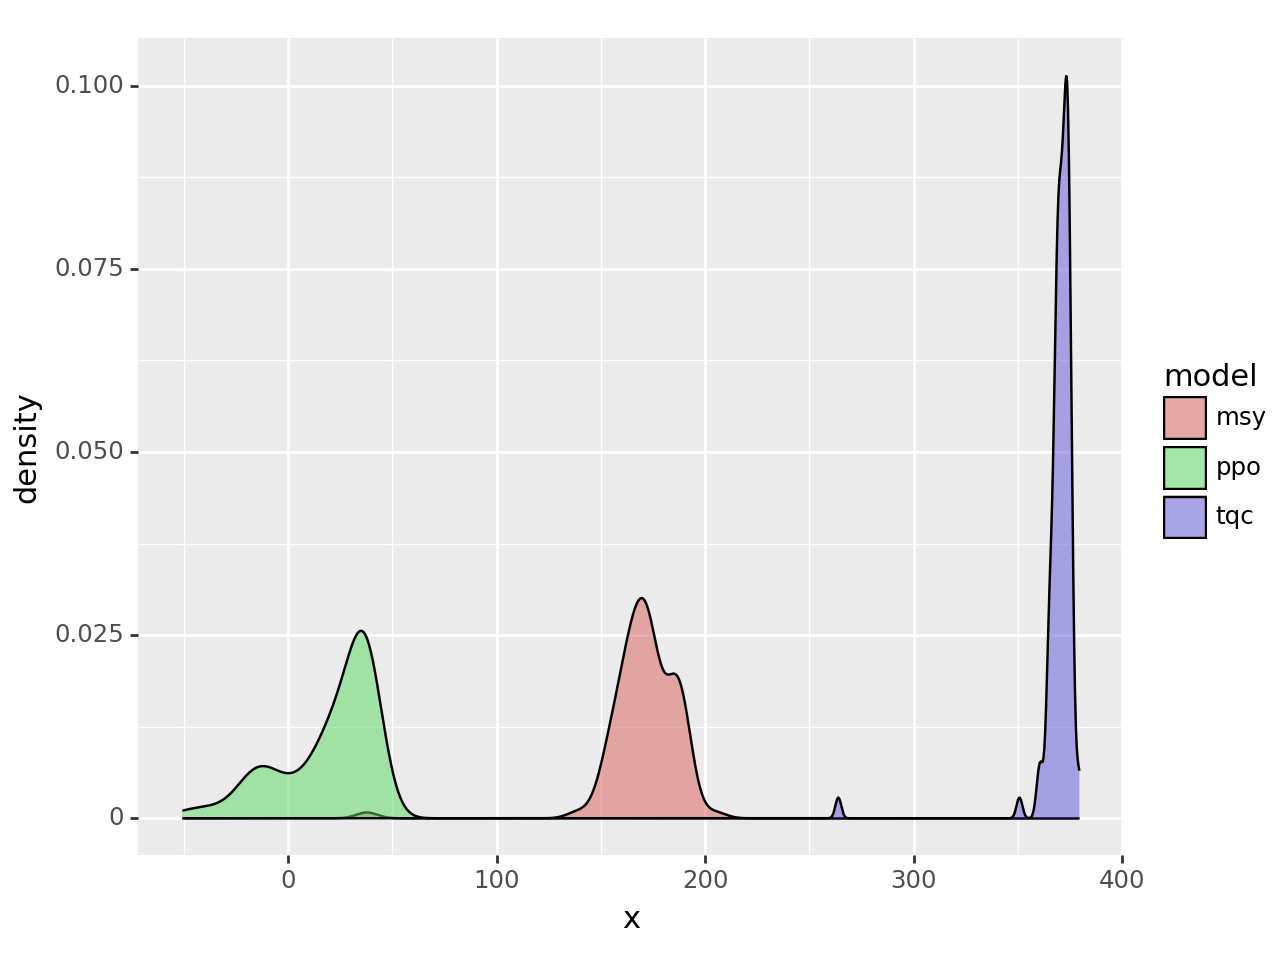

<Figure Size: (640 x 480)>

In [30]:
df_ppo = pl.from_records(ppo_sims, "x").with_columns(pl.lit("ppo").alias("model"))
df_tqc = pl.from_records(tqc_sims, "x").with_columns(pl.lit("tqc").alias("model"))
df_msy = pl.from_records(msy_sims, "x").with_columns(pl.lit("msy").alias("model"))
df = df_tqc.extend(df_ppo).extend(df_msy)

(ggplot(df, aes("x", fill="model")) +#  geom_bar(stat="bin", binwidth=1, alpha=0.5) + 
  geom_density(alpha=0.5) 
)